## Set up

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pytz
import numpy as np
import pandas as pd
import math
import seaborn as sns
import os
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
import warnings
import torch
import itertools

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer, TorchNormalizer
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.metrics.distributions import NegativeBinomialDistributionLoss

from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch import Trainer

from datetime import datetime, timedelta
from tqdm import tqdm

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

np.random.seed(42)

In [4]:
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(math.log10(abs(num)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num_str = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  return f'{num_str}{letters[int(scale)]}'

def mpl_human_format(x, pos):
  """Formatter for matplotlib to use human_format."""
  if pos is not None:
    return human_format(x)
  return ''

def make_axes_human_readable(ax, axis="y"):
  """Apply human readable formatting to the specified axis of a matplotlib axes object."""
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise ValueError("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(ticker.FuncFormatter(mpl_human_format))
  return ax

## Import the data

In [6]:
features_df = pd.read_json('../../dataset/combined_retails_and_exog_data/combined_data.json')
features_df

,Date,TimeIdx,Description,AvgPricePerUnitPounds,DayBeforeUnitsSold,DayBeforeLog1pUnitsSold,WeekBeforeUnitsSold,WeekBeforeLog1pUnitsSold,Rolling3DayMeanUnitsSold,Rolling3DayMeanLog1pUnitsSold,...,IsWeekend,DayOfWeek,DayOfMonth,Month,Quarter,CCI,CPI,InterestRate,Unemployment,IsHoliday
0,2009-12-01,1,12 pencils small tube red spotty,0.66,0,0.000000,0,0.000000,0.000000,0.000000,...,False,Tuesday,1,December,Q4,101.64,90.7,0.4517,7.7,False
1,2009-12-02,2,12 pencils small tube red spotty,0.71,45,3.828641,0,0.000000,0.000000,0.000000,...,False,Wednesday,2,December,Q4,101.64,90.7,0.4532,7.7,False
2,2009-12-03,3,12 pencils small tube red spotty,0.69,87,4.477337,0,0.000000,0.000000,0.000000,...,False,Thursday,3,December,Q4,101.64,90.7,0.4522,7.7,False
3,2009-12-04,4,12 pencils small tube red spotty,0.66,34,3.555348,0,0.000000,55.333333,4.031286,...,False,Friday,4,December,Q4,101.64,90.7,0.4502,7.7,False
4,2009-12-05,5,12 pencils small tube red spotty,0.65,84,4.442651,0,0.000000,68.333333,4.238926,...,True,Saturday,5,December,Q4,101.64,90.7,0.4502,7.7,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104933,2011-12-05,735,wood black board ant white finish,7.70,5,1.791759,2,1.098612,9.666667,2.367124,...,False,Monday,5,December,Q4,98.18,95.2,0.5273,8.3,False
104934,2011-12-06,736,wood black board ant white finish,7.95,23,3.178054,8,2.197225,9.333333,2.335375,...,False,Tuesday,6,December,Q4,98.18,95.2,0.5272,8.3,False
104935,2011-12-07,737,wood black board ant white finish,6.92,4,1.609438,29,3.401197,10.666667,2.456736,...,False,Wednesday,7,December,Q4,98.18,95.2,0.5264,8.3,False
104936,2011-12-08,738,wood black board ant white finish,5.05,70,4.262680,36,3.610918,32.333333,3.506558,...,False,Thursday,8,December,Q4,98.18,95.2,0.5392,8.3,False


In [11]:
# Make sure we have no NaNs
assert not features_df.isna().any().any()

## Prepare the dataset

In [61]:
tft_df = features_df[[
    'Date',
    'Description',
    'UnitsSold',  # target
    'AvgPricePerUnitPounds',
    'CCI',
    'CPI',
    'InterestRate',
    'Unemployment',
    'DayBeforeUnitsSold',
    'WeekBeforeUnitsSold',
    'Rolling3DayMeanUnitsSold',
    'Rolling7DayMeanUnitsSold',
    'IsWeekend',
    'IsHoliday',
    'DayOfWeek',
    'Month',
    'Quarter',
]].copy()

# Convert calendar categoricals to integer codes
categorical_cols = ['DayOfWeek', 'Month', 'Quarter']
for col in categorical_cols:
    tft_df[col] = pd.Categorical(tft_df[col]).codes  # or .astype("category").cat.codes

# Ensure boolean flags are 0/1 integers
bool_cols = ['IsWeekend', 'IsHoliday']
for col in bool_cols:
    tft_df[col] = tft_df[col].astype(int)

# Define lag and calendar features
lag_features = [
    'DayBeforeUnitsSold',
    'WeekBeforeUnitsSold',
    'Rolling3DayMeanUnitsSold',
    'Rolling7DayMeanUnitsSold',
]
calendar_features = ['IsWeekend', 'IsHoliday']

# Add interaction terms
for lag, cal in itertools.product(lag_features, calendar_features):
    interaction_name = f"{lag}_x_{cal}"
    tft_df[interaction_name] = tft_df[lag] * tft_df[cal]

# Add time index per product
tft_df.insert(
    1,
    'TimeIdx',
    tft_df
    .sort_values(['Description', 'Date'])
    .groupby('Description')
    .cumcount() + 1
)

tft_df['IsWeekend'] = tft_df['IsWeekend'].astype('str')
tft_df['IsHoliday'] = tft_df['IsHoliday'].astype('str')
tft_df['DayOfWeek'] = tft_df['DayOfWeek'].astype('str')
tft_df['Month'] = tft_df['Month'].astype('str')
tft_df['Quarter'] = tft_df['Quarter'].astype('str')

tft_df["UnitsSold"] = tft_df["UnitsSold"].astype("float")

print(tft_df.columns)
tft_df

Index(['Date', 'TimeIdx', 'Description', 'UnitsSold', 'AvgPricePerUnitPounds',
       'CCI', 'CPI', 'InterestRate', 'Unemployment', 'DayBeforeUnitsSold',
       'WeekBeforeUnitsSold', 'Rolling3DayMeanUnitsSold',
       'Rolling7DayMeanUnitsSold', 'IsWeekend', 'IsHoliday', 'DayOfWeek',
       'Month', 'Quarter', 'DayBeforeUnitsSold_x_IsWeekend',
       'DayBeforeUnitsSold_x_IsHoliday', 'WeekBeforeUnitsSold_x_IsWeekend',
       'WeekBeforeUnitsSold_x_IsHoliday',
       'Rolling3DayMeanUnitsSold_x_IsWeekend',
       'Rolling3DayMeanUnitsSold_x_IsHoliday',
       'Rolling7DayMeanUnitsSold_x_IsWeekend',
       'Rolling7DayMeanUnitsSold_x_IsHoliday'],
      dtype='object')


,Date,TimeIdx,Description,UnitsSold,AvgPricePerUnitPounds,CCI,CPI,InterestRate,Unemployment,DayBeforeUnitsSold,...,Month,Quarter,DayBeforeUnitsSold_x_IsWeekend,DayBeforeUnitsSold_x_IsHoliday,WeekBeforeUnitsSold_x_IsWeekend,WeekBeforeUnitsSold_x_IsHoliday,Rolling3DayMeanUnitsSold_x_IsWeekend,Rolling3DayMeanUnitsSold_x_IsHoliday,Rolling7DayMeanUnitsSold_x_IsWeekend,Rolling7DayMeanUnitsSold_x_IsHoliday
0,2009-12-01,1,12 pencils small tube red spotty,45.0,0.66,101.64,90.7,0.4517,7.7,0,...,2,3,0,0,0,0,0.000000,0.0,0.0,0.0
1,2009-12-02,2,12 pencils small tube red spotty,87.0,0.71,101.64,90.7,0.4532,7.7,45,...,2,3,0,0,0,0,0.000000,0.0,0.0,0.0
2,2009-12-03,3,12 pencils small tube red spotty,34.0,0.69,101.64,90.7,0.4522,7.7,87,...,2,3,0,0,0,0,0.000000,0.0,0.0,0.0
3,2009-12-04,4,12 pencils small tube red spotty,84.0,0.66,101.64,90.7,0.4502,7.7,34,...,2,3,0,0,0,0,0.000000,0.0,0.0,0.0
4,2009-12-05,5,12 pencils small tube red spotty,0.0,0.65,101.64,90.7,0.4502,7.7,84,...,2,3,84,0,0,0,68.333333,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104933,2011-12-05,735,wood black board ant white finish,23.0,7.70,98.18,95.2,0.5273,8.3,5,...,2,3,0,0,0,0,0.000000,0.0,0.0,0.0
104934,2011-12-06,736,wood black board ant white finish,4.0,7.95,98.18,95.2,0.5272,8.3,23,...,2,3,0,0,0,0,0.000000,0.0,0.0,0.0
104935,2011-12-07,737,wood black board ant white finish,70.0,6.92,98.18,95.2,0.5264,8.3,4,...,2,3,0,0,0,0,0.000000,0.0,0.0,0.0
104936,2011-12-08,738,wood black board ant white finish,226.0,5.05,98.18,95.2,0.5392,8.3,70,...,2,3,0,0,0,0,0.000000,0.0,0.0,0.0


In [68]:
dates = tft_df['Date']
cutoff_train_date = dates.max() - timedelta(days=60)
cutoff_val_date = dates.max() - timedelta(days=30)

train_df = tft_df[dates < cutoff_train_date]
val_df = tft_df[(cutoff_train_date <= dates) & (dates < cutoff_val_date)]
test_df = tft_df[dates >= cutoff_val_date]
val_and_test_df = tft_df[dates >= cutoff_train_date]

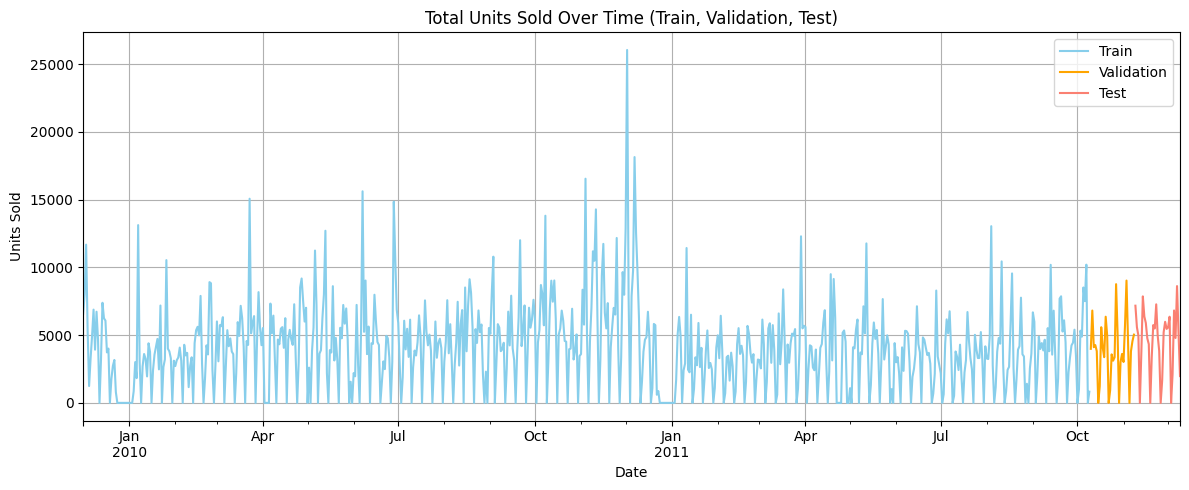

In [63]:
total_train_units_sold = train_df.groupby('Date')['UnitsSold'].sum()
total_val_units_sold = val_df.groupby('Date')['UnitsSold'].sum()
total_test_units_sold = test_df.groupby('Date')['UnitsSold'].sum()

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

total_train_units_sold.sort_index().plot(ax=ax, label="Train", color="skyblue")
total_val_units_sold.sort_index().plot(ax=ax, label="Validation", color="orange")
total_test_units_sold.sort_index().plot(ax=ax, label="Test", color="salmon")

ax.set_title("Total Units Sold Over Time (Train, Validation, Test)")
ax.set_xlabel("Date")
ax.set_ylabel("Units Sold")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

## Explore the best hyper-parameters

In [95]:
base_dataset = TimeSeriesDataSet(
    train_df,
    time_idx="TimeIdx",
    target="UnitsSold",
    group_ids=["Description"],
    max_encoder_length=30,
    min_prediction_length=7,
    max_prediction_length=7,
    static_categoricals=["Description"],
    static_reals=[],
    time_varying_known_categoricals=[
        'IsWeekend',
        'IsHoliday',
        'DayOfWeek',
        'Month',
        'Quarter',
    ],
    time_varying_known_reals=[
        'AvgPricePerUnitPounds',
        'CCI',
        'CPI',
        'InterestRate',
        'Unemployment',
    ],
    time_varying_unknown_reals=[
        'UnitsSold',
        'DayBeforeUnitsSold',
        'WeekBeforeUnitsSold',
        'Rolling3DayMeanUnitsSold',
        'Rolling7DayMeanUnitsSold',
        'DayBeforeUnitsSold_x_IsWeekend',
        'DayBeforeUnitsSold_x_IsHoliday',
        'WeekBeforeUnitsSold_x_IsWeekend',
        'WeekBeforeUnitsSold_x_IsHoliday',
        'Rolling3DayMeanUnitsSold_x_IsWeekend',
        'Rolling3DayMeanUnitsSold_x_IsHoliday',
        'Rolling7DayMeanUnitsSold_x_IsWeekend',
        'Rolling7DayMeanUnitsSold_x_IsHoliday',
    ],
    # Known bug: https://github.com/sktime/pytorch-forecasting/issues/1208
    target_normalizer=TorchNormalizer(method="identity", center=False),
    add_relative_time_idx=True,
    allow_missing_timesteps=False,
)

val_and_test_dataset = TimeSeriesDataSet.from_dataset(
    base_dataset,
    val_and_test_df,
    predict=True,
    stop_randomization=True)

In [96]:
train_dataloader = base_dataset.to_dataloader(train=True, batch_size=64)
val_and_test_dataloader = val_and_test_dataset.to_dataloader(train=False, batch_size=64)

In [100]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, min_delta=1e-4, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs", name="tft_nb_optimization")

study = optimize_hyperparameters(
    train_dataloaders=train_dataloader,
    val_dataloaders=val_and_test_dataloader,
    model_path="optuna_nb_model",
    n_trials=50,
    max_epochs=30,
    loss=NegativeBinomialDistributionLoss(),
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 64),
    attention_head_size_range=(1, 4),
    learning_rate_range=(1e-5, 1e-2),
    dropout_range=(0.0, 0.3),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,
    trainer_kwargs=dict(
        accelerator="cpu",
        callbacks=[early_stop, lr_logger],
        logger=logger,
        limit_train_batches=30,  # remove for full training
    ),
    verbose=True,
)

print("Best parameters:", study.best_trial.params)

[I 2025-05-08 22:32:41,992] A new study created in memory with name: no-name-6232f75a-dd0a-4aeb-8c4a-55f86dc049e8
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=30` reached.
[I 2025-05-08 22:34:26,730] Trial 0 finished with value: 3.585686683654785 and parameters: {'gradient_clip_val': 0.08614969724960748, 'hidden_size': 20, 'dropout': 0.22163749376451955, 'hidden_continuous_size': 14, 'attention_head_size': 4, 'learning_rate': 0.008371618696475694}. Best is trial 0 with value: 3.585686683654785.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[I 2025-05-08 22:34:30,081] Trial 1 finished with value: 13.266791343688965 and parameters: {'gradient_clip_val': 0.038509995714212236, 'hidden_s

Best parameters: {'gradient_clip_val': 0.08614969724960748, 'hidden_size': 20, 'dropout': 0.22163749376451955, 'hidden_continuous_size': 14, 'attention_head_size': 4, 'learning_rate': 0.008371618696475694}


In [101]:
print("Best parameters:", study.best_trial.params)
print("Best loss:", study.best_value)

Best parameters: {'gradient_clip_val': 0.08614969724960748, 'hidden_size': 20, 'dropout': 0.22163749376451955, 'hidden_continuous_size': 14, 'attention_head_size': 4, 'learning_rate': 0.008371618696475694}
Best loss: 3.585686683654785


## Train the model

In [103]:
train_dataset = TimeSeriesDataSet(
    train_df,
    time_idx="TimeIdx",
    target="UnitsSold",
    group_ids=["Description"],
    max_encoder_length=30,
    min_prediction_length=7,
    max_prediction_length=7,
    static_categoricals=["Description"],
    static_reals=[],
    time_varying_known_categoricals=[
        'IsWeekend',
        'IsHoliday',
        'DayOfWeek',
        'Month',
        'Quarter',
    ],
    time_varying_known_reals=[
        'AvgPricePerUnitPounds',
        'CCI',
        'CPI',
        'InterestRate',
        'Unemployment',
    ],
    time_varying_unknown_reals=[
        'UnitsSold',
        'DayBeforeUnitsSold',
        'WeekBeforeUnitsSold',
        'Rolling3DayMeanUnitsSold',
        'Rolling7DayMeanUnitsSold',
        'DayBeforeUnitsSold_x_IsWeekend',
        'DayBeforeUnitsSold_x_IsHoliday',
        'WeekBeforeUnitsSold_x_IsWeekend',
        'WeekBeforeUnitsSold_x_IsHoliday',
        'Rolling3DayMeanUnitsSold_x_IsWeekend',
        'Rolling3DayMeanUnitsSold_x_IsHoliday',
        'Rolling7DayMeanUnitsSold_x_IsWeekend',
        'Rolling7DayMeanUnitsSold_x_IsHoliday',
    ],
    # Known bug: https://github.com/sktime/pytorch-forecasting/issues/1208
    target_normalizer=TorchNormalizer(method="identity", center=False),
    add_relative_time_idx=True,
    allow_missing_timesteps=False,
)

val_and_test_dataset = TimeSeriesDataSet.from_dataset(
    base_dataset,
    val_and_test_df,
    predict=True,
    stop_randomization=True)

In [104]:
train_dataloader = base_dataset.to_dataloader(train=True, batch_size=64)
val_and_test_dataloader = val_and_test_dataset.to_dataloader(train=False, batch_size=64)

In [105]:
parameters = {
    'gradient_clip_val': 0.08614969724960748,
    'hidden_size': 20,
    'dropout': 0.22163749376451955,
    'hidden_continuous_size': 14,
    'attention_head_size': 4,
    'learning_rate': 0.008371618696475694
}

tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=parameters['learning_rate'],
    hidden_size=parameters['hidden_size'],
    hidden_continuous_size=parameters['hidden_continuous_size'],
    attention_head_size=parameters['attention_head_size'],
    dropout=parameters['dropout'],
    loss=NegativeBinomialDistributionLoss(),
    log_interval=10,
    optimizer='ranger',
    reduce_on_plateau_patience=4,
)

In [ ]:
early_stop = EarlyStopping(monitor="train_loss_epoch", patience=10)
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs", name="tft_final")

trainer = Trainer(
    gradient_clip_val=parameters['gradient_clip_val'],
    accelerator="cpu",  # or "gpu" if available
    callbacks=[early_stop, lr_logger],
    logger=logger,
)

trainer.fit(tft, train_dataloader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                               | Type                             | Params | Mode 
-------------------------------------------------------------------------------------------------
0  | loss                               | NegativeBinomialDistributionLoss | 0      | train
1  | logging_metrics                    | ModuleList                       | 0      | train
2  | input_embeddings                   | MultiEmbedding                   | 3.0 K  | train
3  | prescalers                         | ModuleDict                       | 532    | train
4  | static_variable_selection          | VariableSelectionNetwork         | 60     | train
5  | encoder_variable_selection         | VariableSelectionNetwork         | 29.7 K | train
6  | dec

Training: |          | 0/? [00:00<?, ?it/s]